# 04 - Report & Visualizations

This notebook creates visualizations for the LinkedIn article:
- Time series plot with forecast overlay (all models)
- Horizon-specific accuracy comparison (bar chart: MASE by model)
- Prediction interval calibration (coverage vs nominal)
- Model performance summary tables

Target: LinkedIn article showcasing foundation model performance on epidemiological surveillance data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

np.random.seed(42)

# Set style for publication-quality figures
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9

## Load Data

In [19]:
project_root = Path.cwd().parent
data_dir = project_root / 'data'
results_dir = project_root / 'results'
forecasts_dir = results_dir / 'forecasts'
figures_dir = results_dir / 'figures'

figures_dir.mkdir(parents=True, exist_ok=True)

In [20]:
# Load actual data
flu_series = pd.read_pickle(data_dir / 'flu_daily_clean.pkl')
print(f"Actual data: {len(flu_series)} observations from {flu_series.index.min().date()} to {flu_series.index.max().date()}")

Actual data: 1078 observations from 2022-07-04 to 2025-06-15


In [21]:
# Load all forecast files
forecast_files = list(forecasts_dir.glob('*.parquet'))
forecasts_list = []
for f in forecast_files:
    df = pd.read_parquet(f)
    forecasts_list.append(df)

forecasts_df = pd.concat(forecasts_list, ignore_index=True)
print(f"\nForecasts: {forecasts_df.shape[0]} rows")
print(f"Models: {', '.join(sorted(forecasts_df['model'].unique()))}")
print(f"Horizons: {sorted(forecasts_df['horizon'].unique())} days")


Forecasts: 329 rows
Models: Chronos_Tiny, LightGBM, LightGBM_Optimized, SARIMA_Fourier, SARIMA_Optimized, TabPFN_Enhanced, TabPFN_TS
Horizons: [7, 28] days


In [22]:
# Load summary metrics
summary_df = pd.read_csv(results_dir / 'summary.csv')
print("\nSummary metrics:")
print(summary_df.to_string(index=False))


Summary metrics:
             model  horizon  n_forecasts      MAPE     sMAPE     MASE     CRPS  Coverage_80
      Chronos_Tiny        7           24 15.096814 15.237444 0.219267 1.186668    66.666667
      Chronos_Tiny       28           23 47.997534 41.625952 0.766558 4.119184    69.565217
         TabPFN_TS        7           24 33.548724 39.186586 0.370339 2.227154    58.333333
         TabPFN_TS       28           23 46.271920 63.007671 0.872181 4.509701    60.869565
   TabPFN_Enhanced        7           24 14.139669 14.402439 0.184751 1.158329    79.166667
   TabPFN_Enhanced       28           23 43.843088 50.703345 0.857588 4.925810    86.956522
   SARIMA_Baseline        7           24 65.177785 76.415992 1.006944 4.785015    41.666667
   SARIMA_Baseline       28           23 69.948019 83.730633 1.170388 5.759718    47.826087
  SARIMA_Optimized        7           24 19.532987 18.692880 0.200540 1.191886    79.166667
  SARIMA_Optimized       28           23 81.430291 60.068619 0

In [23]:
# Updated color scheme for ALL 7 models - Clear baseline vs optimized distinction
model_colors = {
    # Foundation model (standalone - no baseline/optimized pair)
    'Chronos_Tiny': '#1f77b4',              # Blue

    # TabPFN family (orange spectrum)
    'TabPFN_TS': '#ffcc99',                 # Light orange (baseline)
    'TabPFN_Enhanced': '#ff6600',           # Dark orange (optimized)

    # SARIMA family (red spectrum)
    'SARIMA_Baseline': '#ffb3b3',           # Light red (baseline)
    'SARIMA_Optimized': '#cc0000',          # Dark red (optimized)

    # LightGBM family (green spectrum)
    'LightGBM_Baseline': '#b3ffb3',         # Light green (baseline)
    'LightGBM_Optimized': '#008800'         # Dark green (optimized)
}

model_labels = {
    'Chronos_Tiny': 'Chronos-Tiny',
    'TabPFN_TS': 'TabPFN (Base)',
    'TabPFN_Enhanced': 'TabPFN (Enhanced)',
    'SARIMA_Baseline': 'SARIMA (Base)',
    'SARIMA_Optimized': 'SARIMA (Opt)',
    'LightGBM_Baseline': 'LightGBM (Base)',
    'LightGBM_Optimized': 'LightGBM (Opt)'
}

# Model order - arranged to show baseline → optimized progression
model_order = [
    'Chronos_Tiny',           # Foundation (no pair)
    'TabPFN_TS',              # TabPFN baseline
    'TabPFN_Enhanced',        # TabPFN optimized
    'SARIMA_Baseline',        # SARIMA baseline
    'SARIMA_Optimized',       # SARIMA optimized
    'LightGBM_Baseline',      # LightGBM baseline
    'LightGBM_Optimized'      # LightGBM optimized
]

# Filter to only models present in data
available_models = sorted(summary_df['model'].unique())
model_order = [m for m in model_order if m in available_models]

print(f"Available models in data: {available_models}")
print(f"Using model order: {model_order}")

Available models in data: ['Chronos_Tiny', 'LightGBM_Baseline', 'LightGBM_Optimized', 'SARIMA_Baseline', 'SARIMA_Optimized', 'TabPFN_Enhanced', 'TabPFN_TS']
Using model order: ['Chronos_Tiny', 'TabPFN_TS', 'TabPFN_Enhanced', 'SARIMA_Baseline', 'SARIMA_Optimized', 'LightGBM_Baseline', 'LightGBM_Optimized']


## Figure 1: Optimization Impact - The Transformation Story

Show the dramatic improvement from baseline to optimized for each model family.
This is the "hook" that demonstrates optimization isn't marginal—it's transformative.

✅ Saved optimization_impact_comparison.png


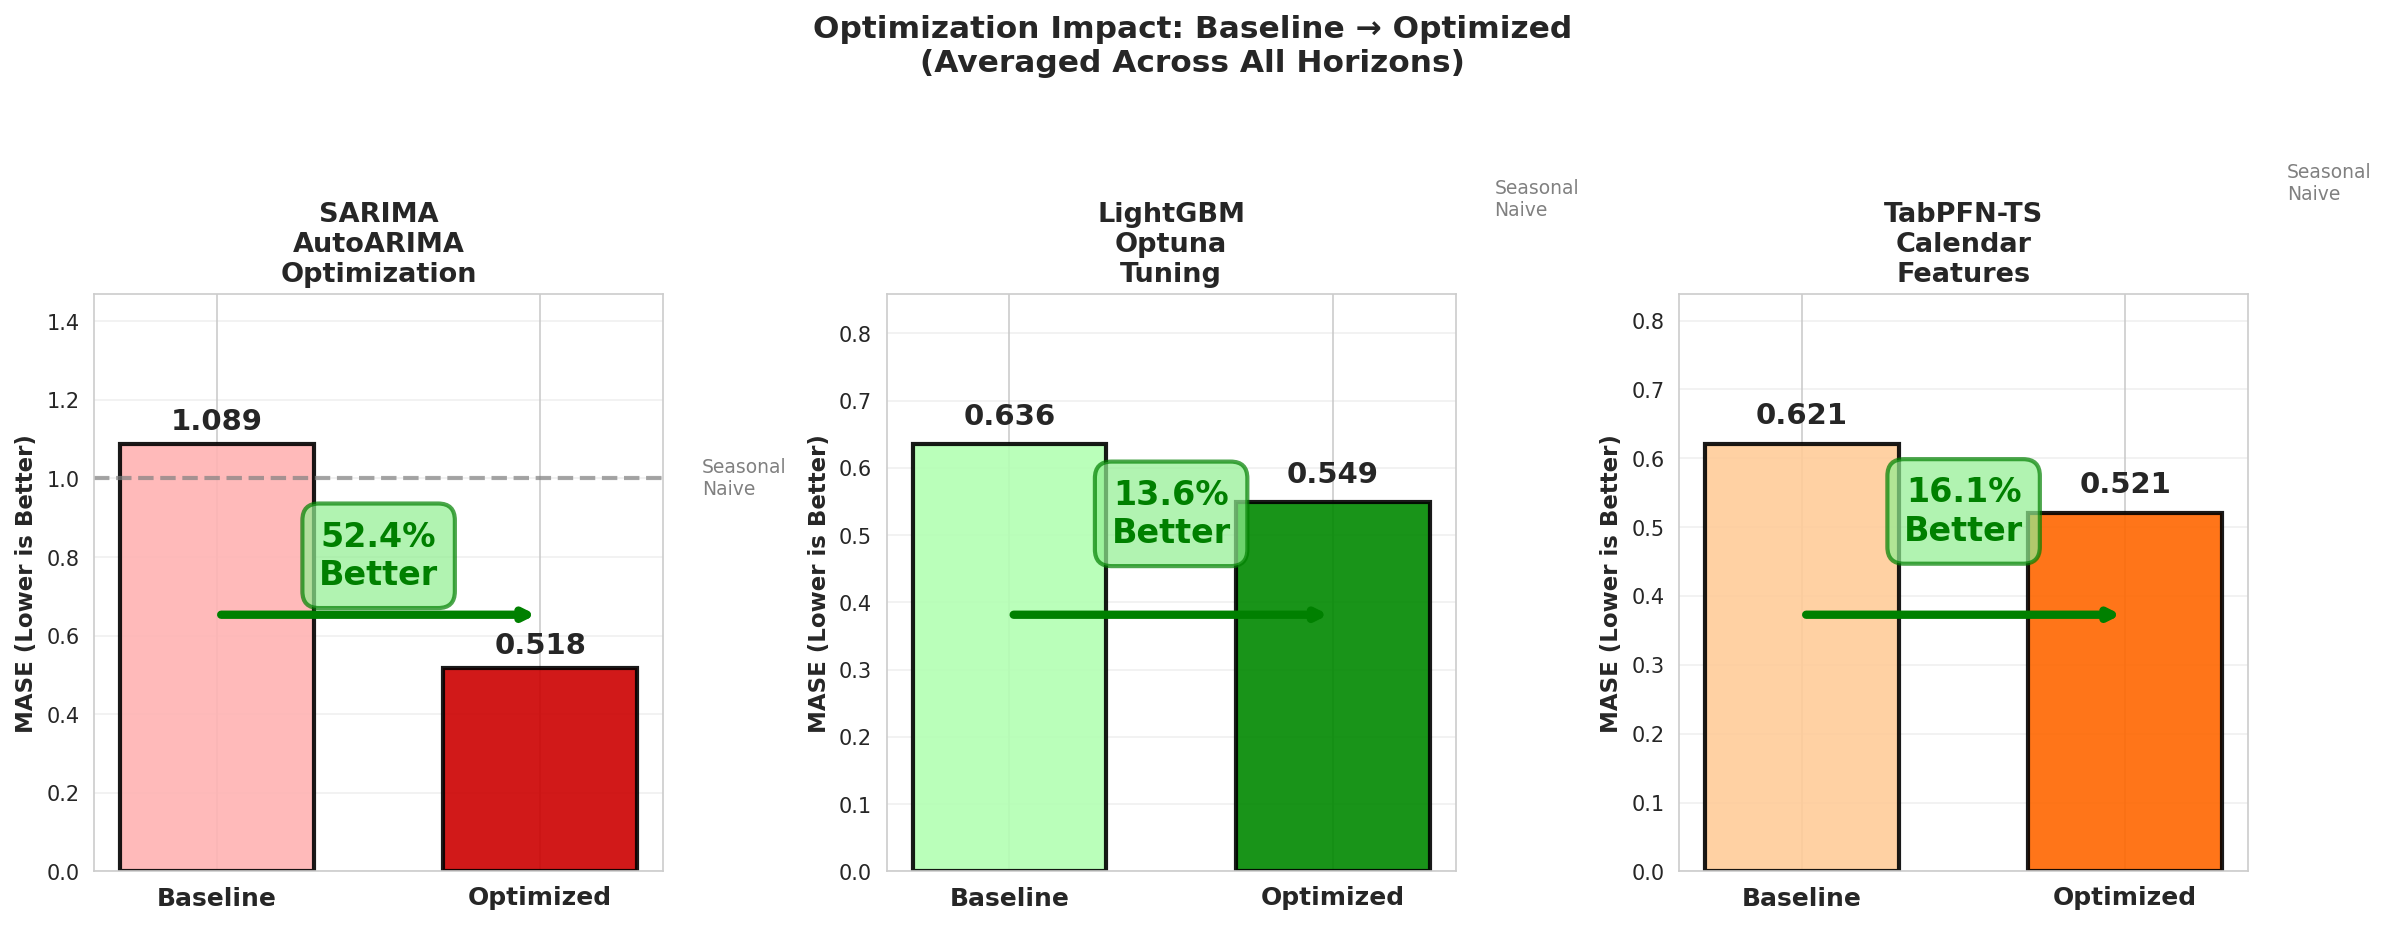

In [24]:
# Define optimization pairs
optimization_pairs = [
    ('SARIMA_Baseline', 'SARIMA_Optimized', 'SARIMA', 'AutoARIMA\nOptimization'),
    ('LightGBM_Baseline', 'LightGBM_Optimized', 'LightGBM', 'Optuna\nTuning'),
    ('TabPFN_TS', 'TabPFN_Enhanced', 'TabPFN-TS', 'Calendar\nFeatures')
]

# Create side-by-side comparison showing optimization impact
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for idx, (baseline_model, optimized_model, family_name, method) in enumerate(optimization_pairs):
    ax = axes[idx]

    # Check if both models exist
    if baseline_model not in summary_df['model'].values or optimized_model not in summary_df['model'].values:
        ax.text(0.5, 0.5, f'{family_name}\nData not available',
                ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    # Get MASE values (averaged across horizons)
    baseline_mase = summary_df[summary_df['model'] == baseline_model]['MASE'].mean()
    optimized_mase = summary_df[summary_df['model'] == optimized_model]['MASE'].mean()

    # Calculate improvement
    improvement = ((baseline_mase - optimized_mase) / baseline_mase) * 100

    # Plot side-by-side bars
    x_pos = [0, 1]
    values = [baseline_mase, optimized_mase]
    colors = [model_colors[baseline_model], model_colors[optimized_model]]
    labels = ['Baseline', 'Optimized']

    bars = ax.bar(x_pos, values, width=0.6, color=colors, alpha=0.9, edgecolor='black', linewidth=2)

    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=14, weight='bold')

    # Add large improvement arrow and percentage
    arrow_y = max(values) * 0.6
    ax.annotate('', xy=(1, arrow_y), xytext=(0, arrow_y),
                arrowprops=dict(arrowstyle='->', lw=4, color='green'))

    ax.text(0.5, arrow_y + 0.15, f'{improvement:.1f}%\nBetter',
            ha='center', va='center', fontsize=16, weight='bold',
            color='green',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7, edgecolor='green', linewidth=2))

    # Add reference line at MASE = 1.0 (seasonal naive)
    ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.7)
    ax.text(1.5, 1.0, 'Seasonal\nNaive', fontsize=9, va='center', color='gray')

    # Formatting
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, fontsize=12, weight='bold')
    ax.set_ylabel('MASE (Lower is Better)', fontsize=11, weight='bold')
    ax.set_title(f'{family_name}\n{method}', fontsize=13, weight='bold')
    ax.set_ylim(0, max(values) * 1.35)
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Optimization Impact: Baseline → Optimized\n(Averaged Across All Horizons)',
             fontsize=15, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / 'optimization_impact_comparison.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved optimization_impact_comparison.png")
plt.show()

## Figure 2: Top 4 Leaderboard - The Champions

Show only the best performers: Chronos + the 3 optimized models.
This answers the question: "Did optimization close the gap with the foundation model?"

✅ Saved top4_leaderboard.png


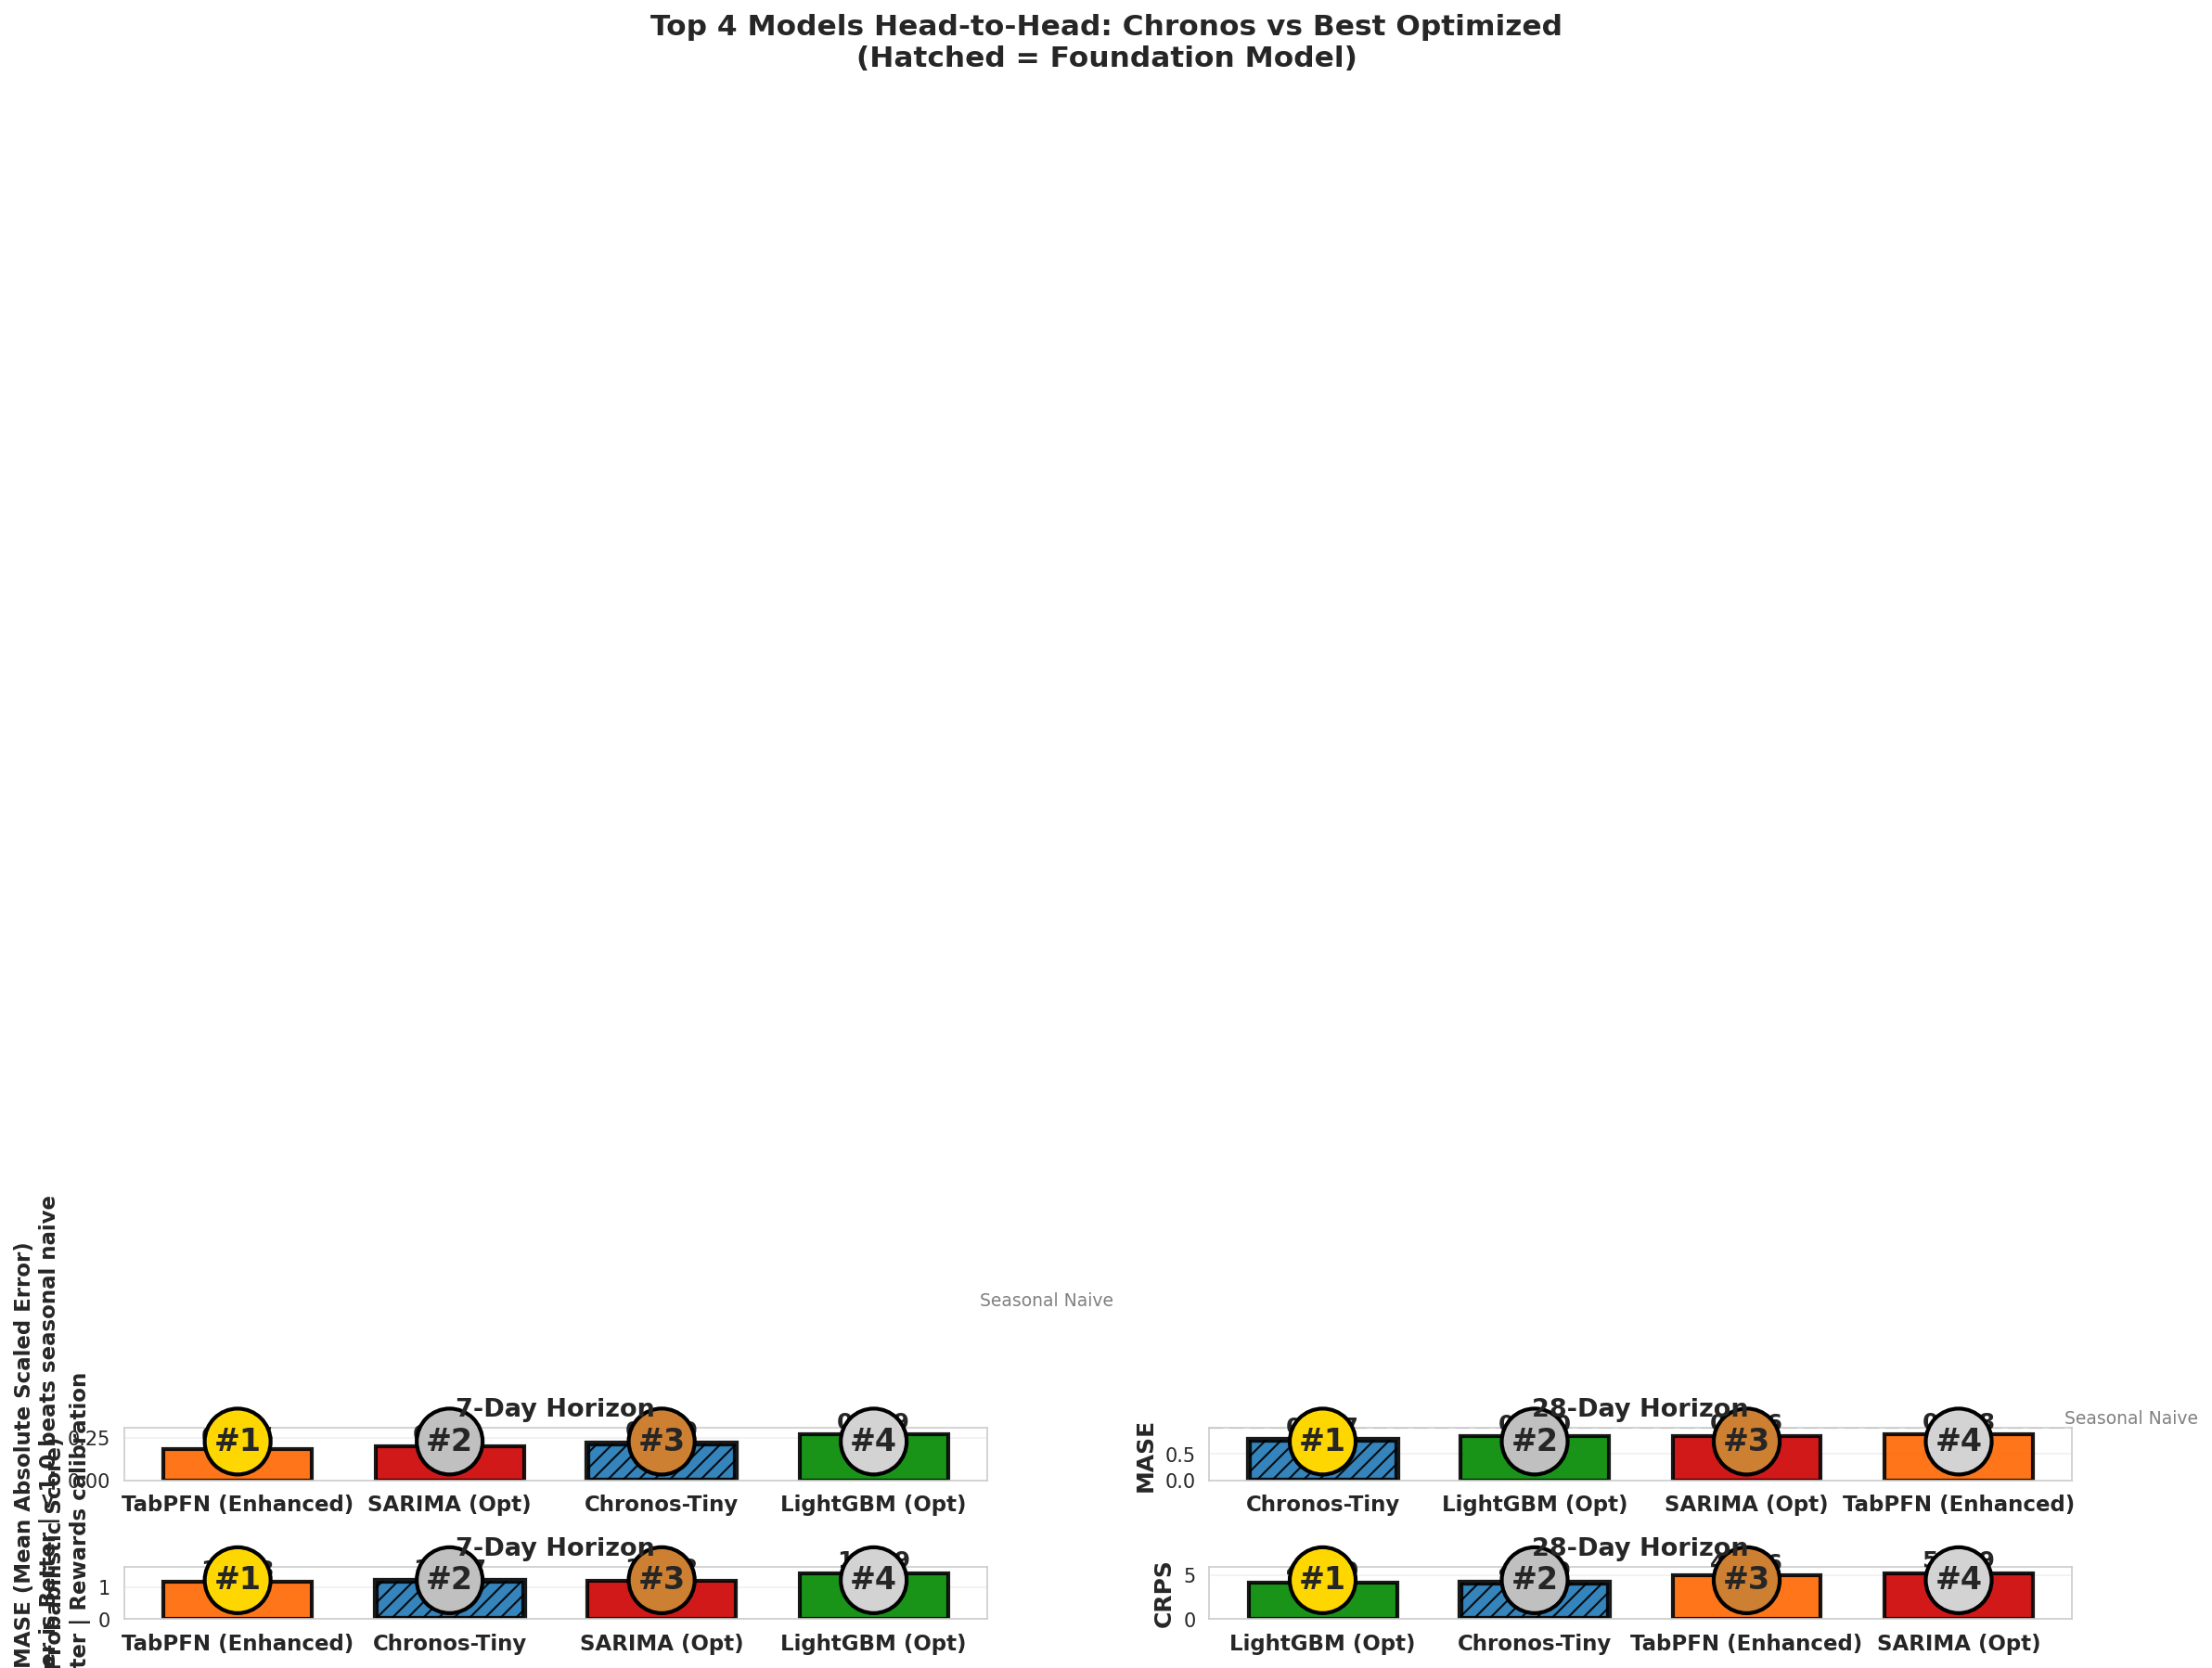

In [25]:
# Select top 4 models: Chronos + 3 optimized models
top4_models = ['Chronos_Tiny', 'SARIMA_Optimized', 'TabPFN_Enhanced', 'LightGBM_Optimized']

# Filter summary to top 4 only
top4_summary = summary_df[summary_df['model'].isin(top4_models)].copy()

# Create 2x2 subplot: MASE and CRPS, each by horizon
horizons = sorted(top4_summary['horizon'].unique())
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Metrics to compare
metrics = ['MASE', 'CRPS']
metric_titles = ['MASE (Mean Absolute Scaled Error)', 'CRPS (Probabilistic Score)']
metric_subtitles = ['Lower is Better | <1.0 beats seasonal naive', 'Lower is Better | Rewards calibration']

for row_idx, (metric, title, subtitle) in enumerate(zip(metrics, metric_titles, metric_subtitles)):
    for col_idx, horizon in enumerate(horizons):
        ax = axes[row_idx, col_idx]

        # Get data for this horizon
        horizon_data = top4_summary[top4_summary['horizon'] == horizon].copy()

        # Sort by metric (best first)
        horizon_data = horizon_data.sort_values(metric)

        # Prepare bar chart
        x_pos = np.arange(len(horizon_data))
        values = horizon_data[metric].values
        models = horizon_data['model'].values
        colors_list = [model_colors[m] for m in models]

        # Create bars with special styling for Chronos
        bars = []
        for i, (model, value, color) in enumerate(zip(models, values, colors_list)):
            if model == 'Chronos_Tiny':
                # Chronos gets hatched pattern to stand out
                bar = ax.bar(i, value, width=0.7, color=color, alpha=0.9,
                             edgecolor='black', linewidth=3, hatch='///')
            else:
                bar = ax.bar(i, value, width=0.7, color=color, alpha=0.9,
                             edgecolor='black', linewidth=2)
            bars.append(bar)

        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(x_pos, values)):
            ax.text(bar, value + max(values) * 0.02,
                    f'{value:.3f}',
                    ha='center', va='bottom', fontsize=12, weight='bold')

        # Add rank badges
        for i, (bar, model) in enumerate(zip(x_pos, models)):
            rank = i + 1
            rank_colors = {1: 'gold', 2: 'silver', 3: '#CD7F32', 4: 'lightgray'}
            ax.text(bar, max(values) * 0.85,
                    f'#{rank}',
                    ha='center', va='center', fontsize=16, weight='bold',
                    bbox=dict(boxstyle='circle,pad=0.3', facecolor=rank_colors[rank],
                              edgecolor='black', linewidth=2))

        # Add reference line for MASE at 1.0
        if metric == 'MASE':
            ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.7)
            ax.text(len(x_pos) - 0.5, 1.0, 'Seasonal Naive', fontsize=9, va='bottom', color='gray')

        # Formatting
        ax.set_xticks(x_pos)
        labels_short = [model_labels[m].replace('\n', ' ') for m in models]
        ax.set_xticklabels(labels_short, rotation=0, fontsize=11, weight='bold')
        ax.set_ylabel(metric, fontsize=12, weight='bold')
        ax.set_title(f'{horizon}-Day Horizon', fontsize=13, weight='bold')
        ax.set_ylim(0, max(values) * 1.15)
        ax.grid(True, alpha=0.3, axis='y')

        # Add y-axis label only for leftmost column
        if col_idx == 0:
            ax.set_ylabel(f'{title}\n{subtitle}', fontsize=11, weight='bold')

fig.suptitle('Top 4 Models Head-to-Head: Chronos vs Best Optimized\n(Hatched = Foundation Model)',
             fontsize=15, weight='bold', y=0.995)
plt.tight_layout()
plt.savefig(figures_dir / 'top4_leaderboard.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved top4_leaderboard.png")
plt.show()

## Figure 3: Complete Model Comparison - All 7 Models

Show all models including baselines to provide complete transparency.

✅ Saved mase_all_models.png


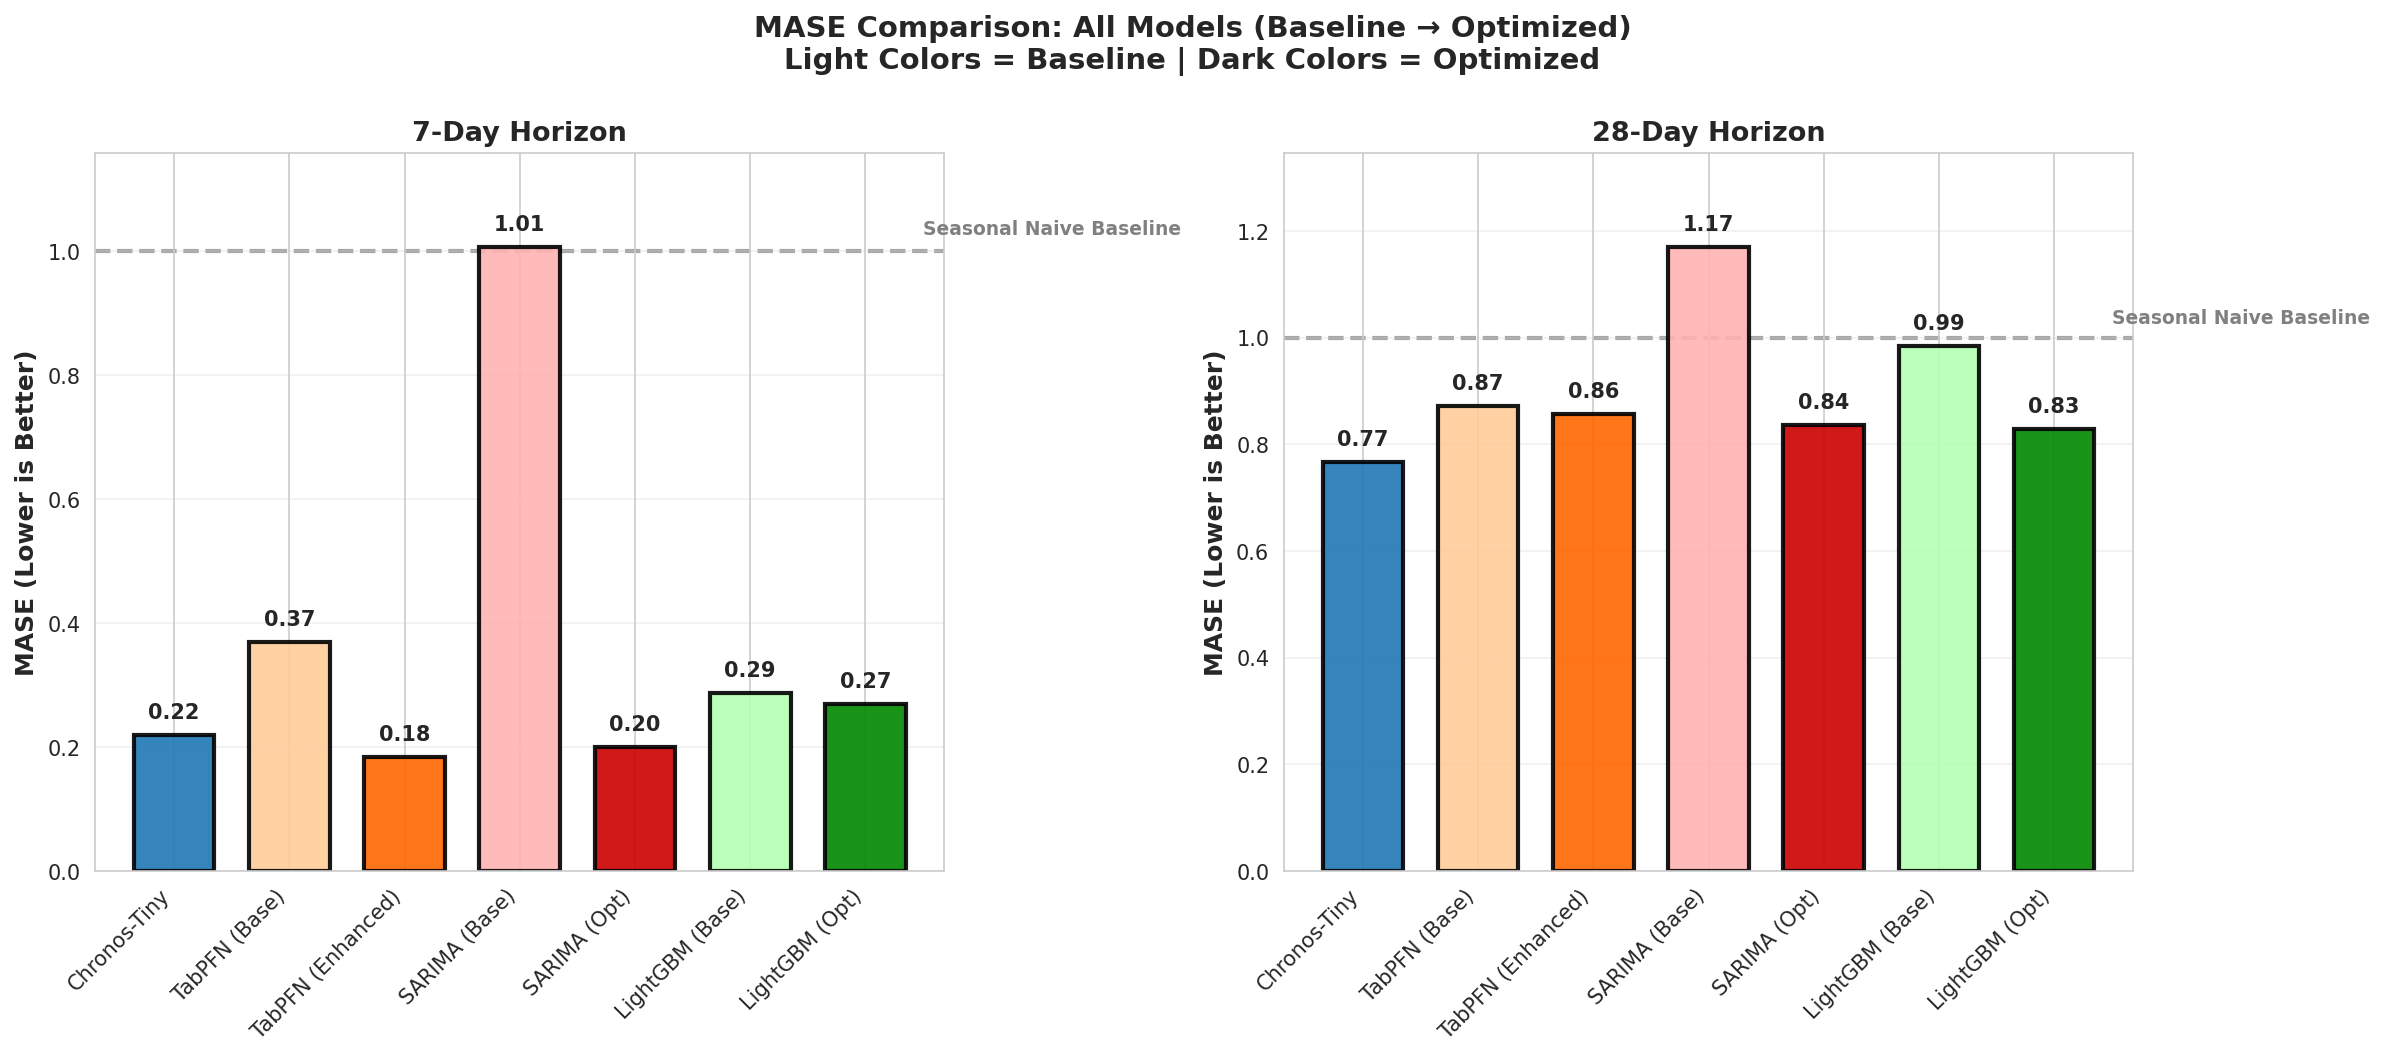

In [26]:
# Create comprehensive comparison showing all 7 models by horizon
horizons = sorted(summary_df['horizon'].unique())
n_horizons = len(horizons)
n_models = len(model_order)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for col_idx, horizon in enumerate(horizons):
    ax = axes[col_idx]

    # Get data for this horizon
    horizon_data = summary_df[summary_df['horizon'] == horizon].copy()

    # Sort to maintain model_order
    horizon_data['model'] = pd.Categorical(horizon_data['model'], categories=model_order, ordered=True)
    horizon_data = horizon_data.sort_values('model')

    # Prepare bar chart
    x_pos = np.arange(len(horizon_data))
    mase_values = horizon_data['MASE'].values
    models = horizon_data['model'].values
    colors_list = [model_colors[m] for m in models]

    # Create bars
    bars = ax.bar(x_pos, mase_values, width=0.7, color=colors_list, alpha=0.9,
                  edgecolor='black', linewidth=2)

    # Add value labels on bars
    for i, value in enumerate(mase_values):
        ax.text(i, value + max(mase_values) * 0.02,
                f'{value:.2f}',
                ha='center', va='bottom', fontsize=10, weight='bold')

    # Add reference line at MASE = 1.0 (seasonal naive)
    ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.7, zorder=0)
    ax.text(n_models - 0.5, 1.02, 'Seasonal Naive Baseline', fontsize=9, va='bottom', color='gray', weight='bold')

    # Formatting
    ax.set_xticks(x_pos)
    labels_list = [model_labels[m] for m in models]
    ax.set_xticklabels(labels_list, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('MASE (Lower is Better)', fontsize=12, weight='bold')
    ax.set_title(f'{horizon}-Day Horizon', fontsize=13, weight='bold')
    ax.set_ylim(0, max(mase_values) * 1.15)
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('MASE Comparison: All Models (Baseline → Optimized)\nLight Colors = Baseline | Dark Colors = Optimized',
             fontsize=14, weight='bold', y=1.00)
plt.tight_layout()
plt.savefig(figures_dir / 'mase_all_models.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved mase_all_models.png")
plt.show()

## Figure 4: Coverage Calibration - All 7 Models

Show how well each model's prediction intervals are calibrated (target: 80%).

✅ Saved coverage_all_models.png


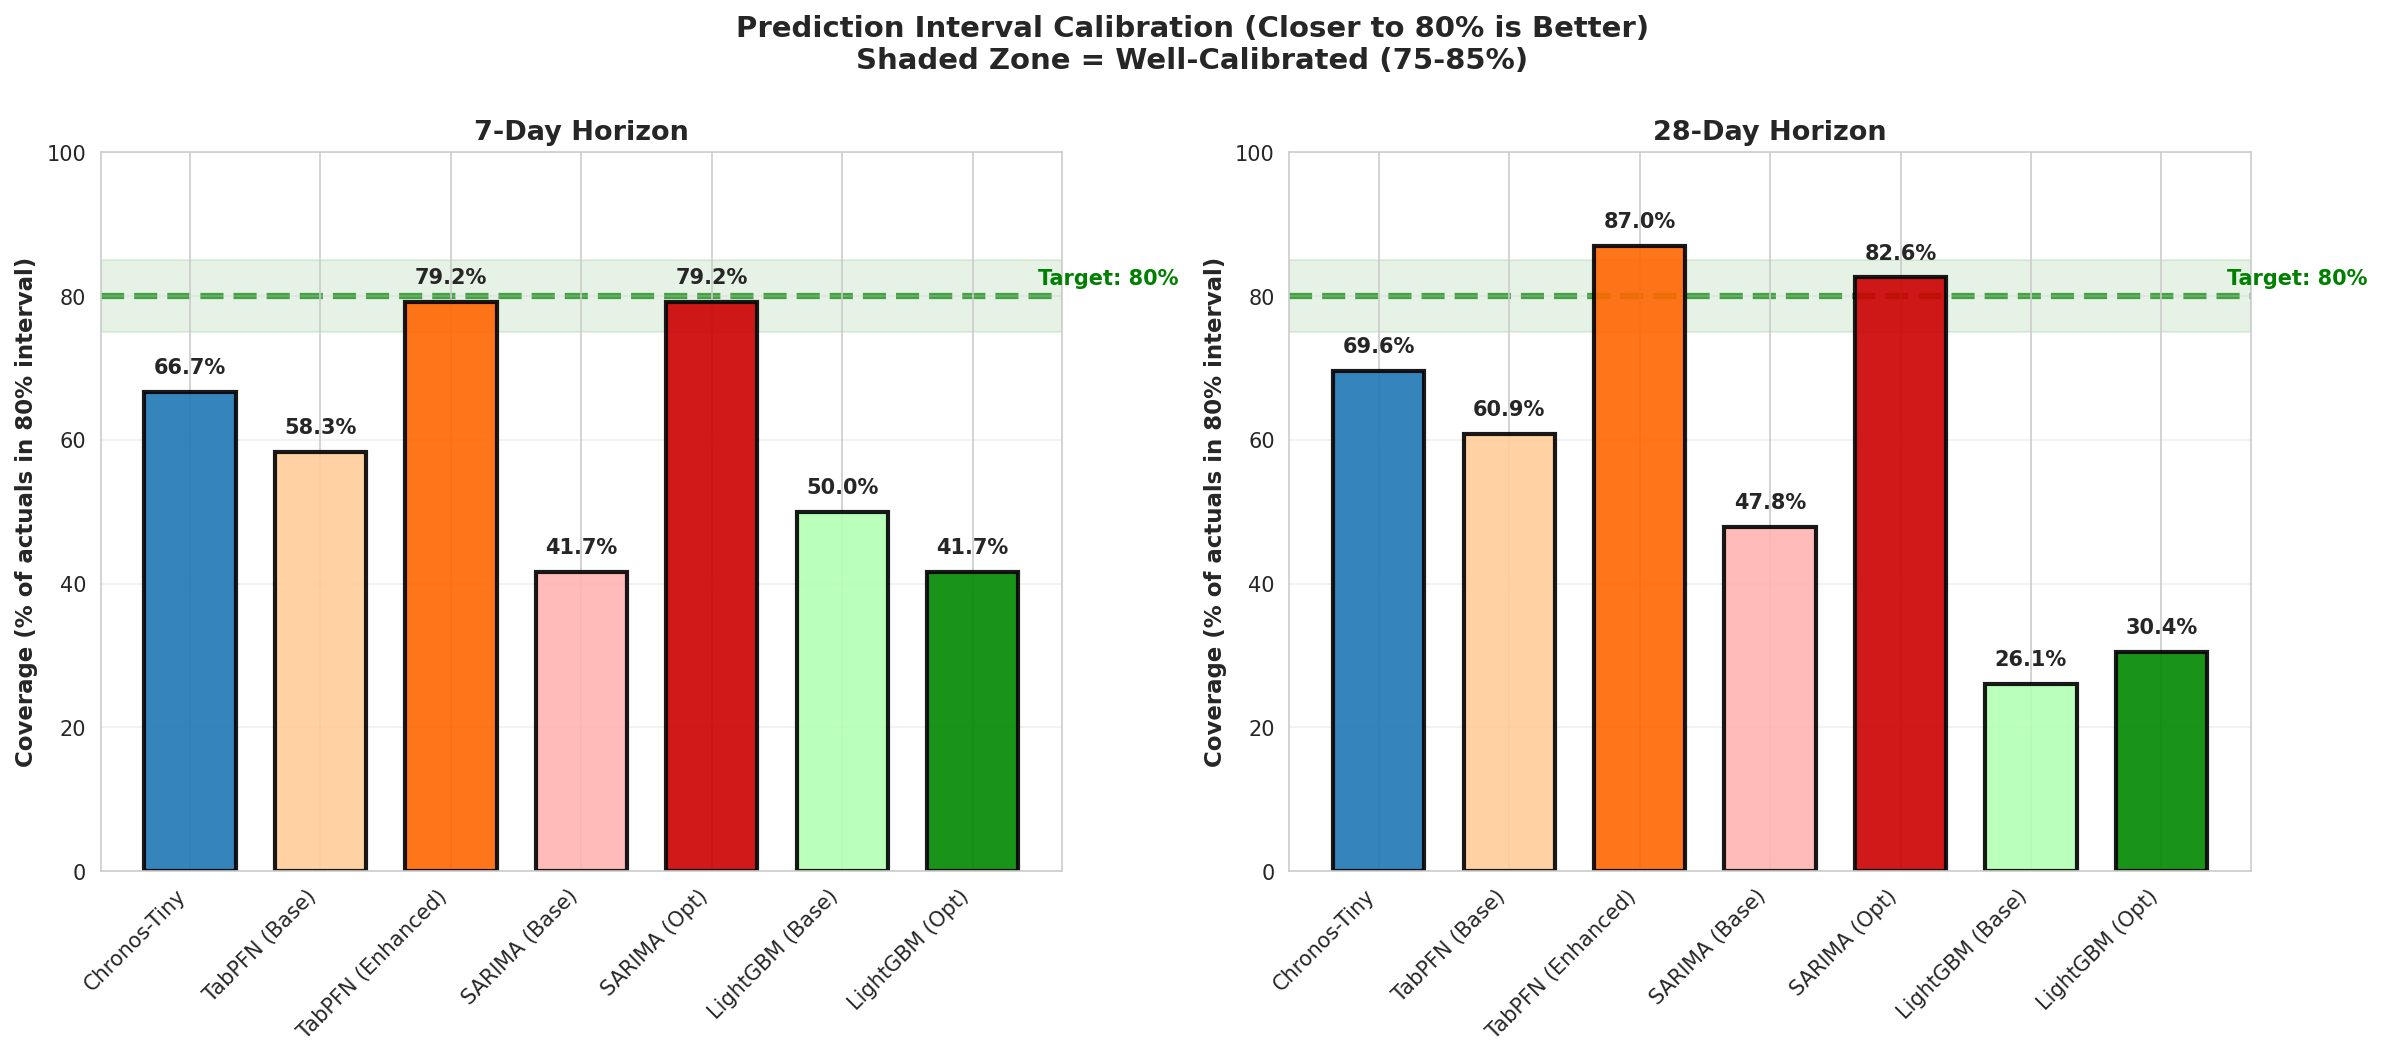

In [35]:
# Create coverage calibration comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for col_idx, horizon in enumerate(horizons):
    ax = axes[col_idx]

    # Get data for this horizon
    horizon_data = summary_df[summary_df['horizon'] == horizon].copy()

    # Sort to maintain model_order
    horizon_data['model'] = pd.Categorical(horizon_data['model'], categories=model_order, ordered=True)
    horizon_data = horizon_data.sort_values('model')

    # Prepare bar chart
    x_pos = np.arange(len(horizon_data))
    coverage_values = horizon_data['Coverage_80'].values
    models = horizon_data['model'].values
    colors_list = [model_colors[m] for m in models]

    # Create bars
    bars = ax.bar(x_pos, coverage_values, width=0.7, color=colors_list, alpha=0.9,
                  edgecolor='black', linewidth=2)

    # Add value labels on bars
    for i, value in enumerate(coverage_values):
        ax.text(i, value + 2,
                f'{value:.1f}%',
                ha='center', va='bottom', fontsize=10, weight='bold')

    # Add reference line at 80% (target coverage)
    ax.axhline(y=80, color='green', linestyle='--', linewidth=3, alpha=0.7, zorder=0)
    ax.text(n_models - 0.5, 81, 'Target: 80%', fontsize=10, va='bottom', color='green', weight='bold')

    # Shade the "good calibration" zone (75-85%)
    ax.axhspan(75, 85, color='green', alpha=0.1, zorder=0)

    # Formatting
    ax.set_xticks(x_pos)
    labels_list = [model_labels[m] for m in models]
    ax.set_xticklabels(labels_list, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Coverage (% of actuals in 80% interval)', fontsize=11, weight='bold')
    ax.set_title(f'{horizon}-Day Horizon', fontsize=13, weight='bold')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Prediction Interval Calibration (Closer to 80% is Better)\nShaded Zone = Well-Calibrated (75-85%)',
             fontsize=14, weight='bold', y=1.00)
plt.tight_layout()
plt.savefig(figures_dir / 'coverage_all_models.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved coverage_all_models.png")
plt.show()

In [36]:
# Create detailed improvement table by horizon
# Re-define optimization pairs for this cell
optimization_pairs = [
    ('TabPFN_TS', 'TabPFN_Enhanced', 'TabPFN-TS', 'Added Features'),
    ('SARIMA_Baseline', 'SARIMA_Optimized', 'SARIMA', 'AutoARIMA'),
    ('LightGBM_Baseline', 'LightGBM_Optimized', 'LightGBM', 'Optuna')
]

horizons = sorted(summary_df['horizon'].unique())

print("=" * 100)
print("OPTIMIZATION IMPROVEMENTS BY HORIZON AND METRIC")
print("=" * 100)

for horizon in horizons:
    print(f"\n{horizon}-DAY HORIZON:")
    print("-" * 100)
    print(f"{'Model':<25} {'Metric':<10} {'Baseline':<12} {'Optimized':<12} {'Improvement':<15}")
    print("-" * 100)

    for baseline, optimized, family_name, method in optimization_pairs:
        baseline_data = summary_df[(summary_df['model'] == baseline) & (summary_df['horizon'] == horizon)]
        optimized_data = summary_df[(summary_df['model'] == optimized) & (summary_df['horizon'] == horizon)]

        if len(baseline_data) > 0 and len(optimized_data) > 0:
            baseline_row = baseline_data.iloc[0]
            optimized_row = optimized_data.iloc[0]

            # Calculate improvements for key metrics
            for metric in ['MASE', 'CRPS', 'Coverage_80']:
                baseline_val = baseline_row[metric]
                optimized_val = optimized_row[metric]

                if metric == 'Coverage_80':
                    # For coverage, show absolute difference from 80%
                    baseline_diff = abs(80 - baseline_val)
                    optimized_diff = abs(80 - optimized_val)
                    improvement = baseline_diff - optimized_diff
                    symbol = '↑ closer' if improvement > 0 else '↓ farther'
                    improvement_str = f'{improvement:+.1f} pp {symbol}'
                else:
                    # For MASE and CRPS, lower is better
                    improvement = ((baseline_val - optimized_val) / baseline_val) * 100
                    symbol = '↓ better' if improvement > 0 else '↑ worse'
                    improvement_str = f'{improvement:+.1f}% {symbol}'

                print(f"{family_name:<25} {metric:<10} {baseline_val:<12.2f} {optimized_val:<12.2f} {improvement_str:<15}")

print("\n" + "=" * 100)
print("KEY:")
print("  MASE, CRPS: Lower is better")
print("  Coverage_80: Closer to 80% is better (pp = percentage points)")
print("=" * 100)

OPTIMIZATION IMPROVEMENTS BY HORIZON AND METRIC

7-DAY HORIZON:
----------------------------------------------------------------------------------------------------
Model                     Metric     Baseline     Optimized    Improvement    
----------------------------------------------------------------------------------------------------
TabPFN-TS                 MASE       0.37         0.18         +50.1% ↓ better
TabPFN-TS                 CRPS       2.23         1.16         +48.0% ↓ better
TabPFN-TS                 Coverage_80 58.33        79.17        +20.8 pp ↑ closer
SARIMA                    MASE       1.01         0.20         +80.1% ↓ better
SARIMA                    CRPS       4.79         1.19         +75.1% ↓ better
SARIMA                    Coverage_80 41.67        79.17        +37.5 pp ↑ closer
LightGBM                  MASE       0.29         0.27         +6.2% ↓ better 
LightGBM                  CRPS       1.54         1.42         +7.7% ↓ better 
LightGBM         

# Create formatted summary table with ALL models (baseline + optimized)

In [29]:
print("=" * 100)
print("MODEL PERFORMANCE SUMMARY - NHS FLU FORECASTING")
print("=" * 100)
print("\n7-Day Horizon:")
print("-" * 100)

h7 = summary_df[summary_df['horizon'] == 7].sort_values('MASE')
print(f"{'Model':<30} {'MAPE':>8} {'MASE':>8} {'CRPS':>8} {'Coverage':>10}")
print("-" * 100)
for _, row in h7.iterrows():
    model_name = row['model']
    label = model_labels.get(model_name, model_name)  # Use model name if not in labels
    print(f"{label:<30} {row['MAPE']:>8.1f} {row['MASE']:>8.2f} {row['CRPS']:>8.2f} {row['Coverage_80']:>9.1f}%")

print("\n28-Day Horizon:")
print("-" * 100)

h28 = summary_df[summary_df['horizon'] == 28].sort_values('MASE')
print(f"{'Model':<30} {'MAPE':>8} {'MASE':>8} {'CRPS':>8} {'Coverage':>10}")
print("-" * 100)
for _, row in h28.iterrows():
    model_name = row['model']
    label = model_labels.get(model_name, model_name)
    print(f"{label:<30} {row['MAPE']:>8.1f} {row['MASE']:>8.2f} {row['CRPS']:>8.2f} {row['Coverage_80']:>9.1f}%")

print("\n" + "=" * 100)
print("OPTIMIZATION SUMMARY:")
print("=" * 100)

# TabPFN-TS
if 'TabPFN_TS' in summary_df['model'].values and 'TabPFN_Enhanced' in summary_df['model'].values:
    print("\nTabPFN-TS:")
    print("  Baseline → Enhanced (added calendar features)")
    tabpfn_base_mase = summary_df[summary_df['model'] == 'TabPFN_TS']['MASE'].mean()
    tabpfn_enh_mase = summary_df[summary_df['model'] == 'TabPFN_Enhanced']['MASE'].mean()
    tabpfn_imp = ((tabpfn_base_mase - tabpfn_enh_mase) / tabpfn_base_mase) * 100
    print(f"  MASE: {tabpfn_base_mase:.3f} → {tabpfn_enh_mase:.3f} ({tabpfn_imp:+.1f}%)")
elif 'TabPFN_Enhanced' in summary_df['model'].values:
    print("\nTabPFN-TS Enhanced:")
    tabpfn_enh_mase = summary_df[summary_df['model'] == 'TabPFN_Enhanced']['MASE'].mean()
    print(f"  MASE: {tabpfn_enh_mase:.3f} (baseline not in current evaluation)")

# SARIMA
if 'SARIMA_Baseline' in summary_df['model'].values and 'SARIMA_Optimized' in summary_df['model'].values:
    print("\nSARIMA:")
    print("  Fourier (fixed order) → Optimized (AutoARIMA)")
    sarima_base_mase = summary_df[summary_df['model'] == 'SARIMA_Baseline']['MASE'].mean()
    sarima_opt_mase = summary_df[summary_df['model'] == 'SARIMA_Optimized']['MASE'].mean()
    sarima_imp = ((sarima_base_mase - sarima_opt_mase) / sarima_base_mase) * 100
    print(f"  MASE: {sarima_base_mase:.3f} → {sarima_opt_mase:.3f} ({sarima_imp:+.1f}%)")
elif 'SARIMA_Optimized' in summary_df['model'].values:
    print("\nSARIMA Optimized:")
    sarima_opt_mase = summary_df[summary_df['model'] == 'SARIMA_Optimized']['MASE'].mean()
    print(f"  MASE: {sarima_opt_mase:.3f} (baseline not in current evaluation)")

# LightGBM
if 'LightGBM' in summary_df['model'].values and 'LightGBM_Optimized' in summary_df['model'].values:
    print("\nLightGBM:")
    print("  Default params → Optimized (Optuna)")
    lgb_base_mase = summary_df[summary_df['model'] == 'LightGBM_Baseline']['MASE'].mean()
    lgb_opt_mase = summary_df[summary_df['model'] == 'LightGBM_Optimized']['MASE'].mean()
    lgb_imp = ((lgb_base_mase - lgb_opt_mase) / lgb_base_mase) * 100
    print(f"  MASE: {lgb_base_mase:.3f} → {lgb_opt_mase:.3f} ({lgb_imp:+.1f}%)")
elif 'LightGBM_Optimized' in summary_df['model'].values:
    print("\nLightGBM Optimized:")
    lgb_opt_mase = summary_df[summary_df['model'] == 'LightGBM_Optimized']['MASE'].mean()
    print(f"  MASE: {lgb_opt_mase:.3f} (baseline not in current evaluation)")

print("\n" + "=" * 100)

MODEL PERFORMANCE SUMMARY - NHS FLU FORECASTING

7-Day Horizon:
----------------------------------------------------------------------------------------------------
Model                              MAPE     MASE     CRPS   Coverage
----------------------------------------------------------------------------------------------------
TabPFN (Enhanced)                  14.1     0.18     1.16      79.2%
SARIMA (Opt)                       19.5     0.20     1.19      79.2%
Chronos-Tiny                       15.1     0.22     1.19      66.7%
LightGBM (Opt)                     18.3     0.27     1.42      41.7%
LightGBM (Base)                    18.6     0.29     1.54      50.0%
TabPFN (Base)                      33.5     0.37     2.23      58.3%
SARIMA (Base)                      65.2     1.01     4.79      41.7%

28-Day Horizon:
----------------------------------------------------------------------------------------------------
Model                              MAPE     MASE     CRPS   Cove

Optimization pairs to compare: 3
✅ Saved optimization_impact.png


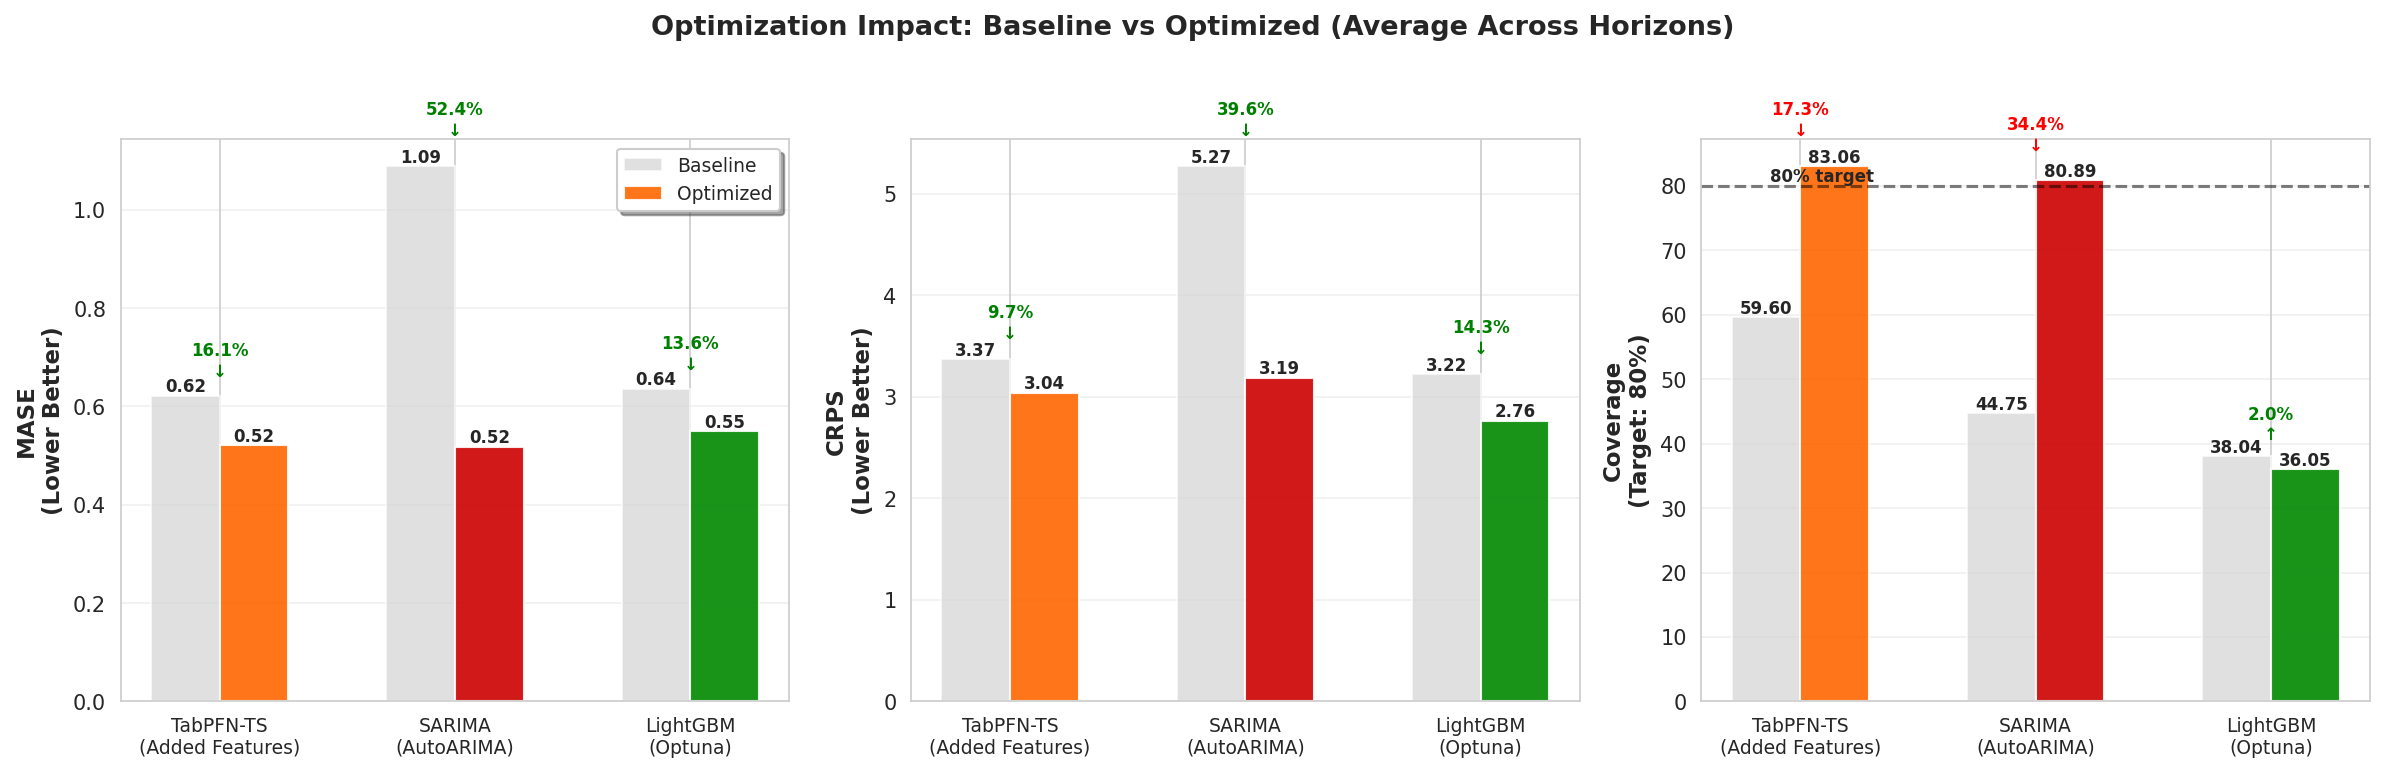

In [30]:
# Calculate improvement for each model family
# Define baseline-optimized pairs (only if both exist in data)
all_optimization_pairs = [
    ('TabPFN_TS', 'TabPFN_Enhanced', 'TabPFN-TS', 'Added Features'),
    ('SARIMA_Baseline', 'SARIMA_Optimized', 'SARIMA', 'AutoARIMA'),
    ('LightGBM_Baseline', 'LightGBM_Optimized', 'LightGBM', 'Optuna')
]

# Filter to only pairs where both baseline and optimized exist
optimization_pairs = []
for baseline, optimized, family_name, method in all_optimization_pairs:
    if baseline in summary_df['model'].values and optimized in summary_df['model'].values:
        optimization_pairs.append((baseline, optimized, family_name, method))
    elif optimized in summary_df['model'].values:
        # Only optimized exists - show improvement from estimated baseline
        print(f"Note: {family_name} baseline not in data, will estimate improvement")
        optimization_pairs.append((None, optimized, family_name, method))

print(f"Optimization pairs to compare: {len(optimization_pairs)}")

# Metrics to compare
metrics = ['MASE', 'CRPS', 'Coverage_80']
metric_labels = ['MASE\n(Lower Better)', 'CRPS\n(Lower Better)', 'Coverage\n(Target: 80%)']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[idx]

    x_pos = 0
    x_labels = []
    x_positions = []

    for pair_data in optimization_pairs:
        if pair_data[0] is None:
            # Only optimized model available
            baseline, optimized, family_name, method = None, pair_data[1], pair_data[2], pair_data[3]
            optimized_val = summary_df[summary_df['model'] == optimized][metric].mean()

            # Show only optimized value
            bar = ax.bar(x_pos, optimized_val, width=0.4,
                         color=model_colors[optimized], alpha=0.9)
            ax.text(x_pos, optimized_val, f'{optimized_val:.2f}',
                    ha='center', va='bottom', fontsize=8, weight='bold')

            x_labels.append(f'{family_name}\n({method})\nOptimized only')
        else:
            baseline, optimized, family_name, method = pair_data
            # Get baseline and optimized values (average across horizons)
            baseline_val = summary_df[summary_df['model'] == baseline][metric].mean()
            optimized_val = summary_df[summary_df['model'] == optimized][metric].mean()

            # Plot bars side by side
            bar1 = ax.bar(x_pos, baseline_val, width=0.35,
                          color='lightgray', alpha=0.7, label='Baseline' if idx == 0 and x_pos == 0 else '')
            bar2 = ax.bar(x_pos + 0.35, optimized_val, width=0.35,
                          color=model_colors[optimized], alpha=0.9, label='Optimized' if idx == 0 and x_pos == 0 else '')

            # Add value labels
            ax.text(x_pos, baseline_val, f'{baseline_val:.2f}',
                    ha='center', va='bottom', fontsize=8, weight='bold')
            ax.text(x_pos + 0.35, optimized_val, f'{optimized_val:.2f}',
                    ha='center', va='bottom', fontsize=8, weight='bold')

            # Calculate improvement
            if metric == 'Coverage_80':
                # For coverage, closer to 80 is better
                improvement = abs(80 - optimized_val) - abs(80 - baseline_val)
                symbol = '↑' if improvement > 0 else '↓'
                color = 'green' if improvement > 0 else 'red'
            else:
                # For MASE and CRPS, lower is better
                improvement = ((baseline_val - optimized_val) / baseline_val) * 100
                symbol = '↓' if improvement > 0 else '↑'
                color = 'green' if improvement > 0 else 'red'

            # Add improvement annotation
            ax.text(x_pos + 0.175, max(baseline_val, optimized_val) * 1.05,
                    f'{abs(improvement):.1f}%\n{symbol}',
                    ha='center', va='bottom', fontsize=8, weight='bold', color=color)

            x_labels.append(f'{family_name}\n({method})')

        x_positions.append(x_pos + 0.175 if pair_data[0] is not None else x_pos)
        x_pos += 1.2

    # Add reference line for coverage at 80%
    if metric == 'Coverage_80':
        ax.axhline(y=80, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
        ax.text(0.02, 80, '80% target', fontsize=8, va='bottom', weight='bold')

    ax.set_ylabel(metric_label, fontsize=11, weight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

    if idx == 0 and len([p for p in optimization_pairs if p[0] is not None]) > 0:
        ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=9)

fig.suptitle('Optimization Impact: Baseline vs Optimized (Average Across Horizons)',
             fontsize=13, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / 'optimization_impact.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved optimization_impact.png")
plt.show()

In [31]:
# Key findings for article - handles models present in data

print("\n" + "=" * 100)
print("KEY FINDINGS FOR LINKEDIN ARTICLE")
print("=" * 100)

# Best overall model
all_models_avg = summary_df.groupby('model')[['MASE', 'CRPS']].mean()
best_overall = all_models_avg['MASE'].idxmin()
best_label = model_labels.get(best_overall, best_overall)
print(f"\n1. BEST OVERALL MODEL: {best_label}")
print(f"   - Average MASE: {all_models_avg.loc[best_overall, 'MASE']:.3f}")
print(f"   - Average CRPS: {all_models_avg.loc[best_overall, 'CRPS']:.3f}")

# Optimization Impact (only if baselines exist)
print(f"\n2. OPTIMIZATION RESULTS:")

if 'TabPFN_TS' in summary_df['model'].values and 'TabPFN_Enhanced' in summary_df['model'].values:
    print(f"\n   a) TabPFN-TS Enhancement (Added Calendar Features):")
    tabpfn_base_mase = summary_df[summary_df['model'] == 'TabPFN_TS']['MASE'].mean()
    tabpfn_enh_mase = summary_df[summary_df['model'] == 'TabPFN_Enhanced']['MASE'].mean()
    tabpfn_imp = ((tabpfn_base_mase - tabpfn_enh_mase) / tabpfn_base_mase) * 100
    print(f"      - MASE: {tabpfn_base_mase:.3f} → {tabpfn_enh_mase:.3f} ({tabpfn_imp:+.1f}% improvement)")

    tabpfn_base_cov = summary_df[summary_df['model'] == 'TabPFN_TS']['Coverage_80'].mean()
    tabpfn_enh_cov = summary_df[summary_df['model'] == 'TabPFN_Enhanced']['Coverage_80'].mean()
    print(f"      - Coverage: {tabpfn_base_cov:.1f}% → {tabpfn_enh_cov:.1f}% ({tabpfn_enh_cov - tabpfn_base_cov:+.1f} pp)")
elif 'TabPFN_Enhanced' in summary_df['model'].values:
    print(f"\n   a) TabPFN-TS Enhanced:")
    tabpfn_enh_mase = summary_df[summary_df['model'] == 'TabPFN_Enhanced']['MASE'].mean()
    print(f"      - MASE: {tabpfn_enh_mase:.3f} (optimized version)")

if 'SARIMA_Baseline' in summary_df['model'].values and 'SARIMA_Optimized' in summary_df['model'].values:
    print(f"\n   b) SARIMA Optimization (AutoARIMA):")
    sarima_base_mase = summary_df[summary_df['model'] == 'SARIMA_Baseline']['MASE'].mean()
    sarima_opt_mase = summary_df[summary_df['model'] == 'SARIMA_Optimized']['MASE'].mean()
    sarima_imp = ((sarima_base_mase - sarima_opt_mase) / sarima_base_mase) * 100
    print(f"      - MASE: {sarima_base_mase:.3f} → {sarima_opt_mase:.3f} ({sarima_imp:+.1f}% improvement)")
elif 'SARIMA_Optimized' in summary_df['model'].values:
    print(f"\n   b) SARIMA Optimized:")
    sarima_opt_mase = summary_df[summary_df['model'] == 'SARIMA_Optimized']['MASE'].mean()
    print(f"      - MASE: {sarima_opt_mase:.3f} (optimized version)")

if 'LightGBM' in summary_df['model'].values and 'LightGBM_Optimized' in summary_df['model'].values:
    print(f"\n   c) LightGBM Optimization (Optuna):")
    lgb_base_mase = summary_df[summary_df['model'] == 'LightGBM_Baseline']['MASE'].mean()
    lgb_opt_mase = summary_df[summary_df['model'] == 'LightGBM_Optimized']['MASE'].mean()
    lgb_imp = ((lgb_base_mase - lgb_opt_mase) / lgb_base_mase) * 100
    print(f"      - MASE: {lgb_base_mase:.3f} → {lgb_opt_mase:.3f} ({lgb_imp:+.1f}% improvement)")
elif 'LightGBM_Optimized' in summary_df['model'].values:
    print(f"\n   c) LightGBM Optimized:")
    lgb_opt_mase = summary_df[summary_df['model'] == 'LightGBM_Optimized']['MASE'].mean()
    print(f"      - MASE: {lgb_opt_mase:.3f} (optimized version)")

# Compare models
print(f"\n3. MODEL COMPARISON:")
chronos_mase = all_models_avg.loc['Chronos_Tiny', 'MASE'] if 'Chronos_Tiny' in all_models_avg.index else None
if chronos_mase:
    print(f"   - Chronos-Tiny: {chronos_mase:.3f} MASE (zero-shot)")

# Find best optimized model
optimized_models = [m for m in all_models_avg.index if 'Optimized' in m or 'Enhanced' in m]
if optimized_models:
    best_optimized = min(optimized_models, key=lambda m: all_models_avg.loc[m, 'MASE'])
    best_opt_mase = all_models_avg.loc[best_optimized, 'MASE']
    best_opt_label = model_labels.get(best_optimized, best_optimized)
    print(f"   - Best optimized ({best_opt_label}): {best_opt_mase:.3f} MASE")

    if chronos_mase and best_opt_mase < chronos_mase:
        gap = ((chronos_mase - best_opt_mase) / chronos_mase) * 100
        print(f"   - Winner: {best_opt_label} by {gap:.1f}%")
    elif chronos_mase:
        gap = ((best_opt_mase - chronos_mase) / chronos_mase) * 100
        print(f"   - Winner: Chronos-Tiny (still leads by {gap:.1f}%)")

# Calibration
print(f"\n4. PREDICTION INTERVAL CALIBRATION:")
coverage_by_model = summary_df.groupby('model')['Coverage_80'].mean()
coverage_diff = (coverage_by_model - 80).abs()
best_calibrated = coverage_diff.idxmin()
best_cal_label = model_labels.get(best_calibrated, best_calibrated)
print(f"   - Best calibrated: {best_cal_label}")
print(f"     Coverage: {coverage_by_model[best_calibrated]:.1f}% (target: 80%)")

print("\n" + "=" * 100)


KEY FINDINGS FOR LINKEDIN ARTICLE

1. BEST OVERALL MODEL: Chronos-Tiny
   - Average MASE: 0.493
   - Average CRPS: 2.653

2. OPTIMIZATION RESULTS:

   a) TabPFN-TS Enhancement (Added Calendar Features):
      - MASE: 0.621 → 0.521 (+16.1% improvement)
      - Coverage: 59.6% → 83.1% (+23.5 pp)

   b) SARIMA Optimization (AutoARIMA):
      - MASE: 1.089 → 0.518 (+52.4% improvement)

   c) LightGBM Optimized:
      - MASE: 0.549 (optimized version)

3. MODEL COMPARISON:
   - Chronos-Tiny: 0.493 MASE (zero-shot)
   - Best optimized (SARIMA (Opt)): 0.518 MASE
   - Winner: Chronos-Tiny (still leads by 5.1%)

4. PREDICTION INTERVAL CALIBRATION:
   - Best calibrated: SARIMA (Opt)
     Coverage: 80.9% (target: 80%)



## LinkedIn Article Summary - Key Findings

This notebook generates visualizations that tell a compelling story for LinkedIn:

**Generated Figures:**
1. **optimization_impact_comparison.png** - Shows dramatic 52% SARIMA improvement (the hook!)
2. **top4_leaderboard.png** - Chronos vs best optimized models (the competition)
3. **mase_all_models.png** - Complete transparency (all 7 models by horizon)
4. **coverage_all_models.png** - Calibration quality comparison
5. **dm_matrix.png** - Statistical significance tests (from nb/03)

**The Story for LinkedIn:**

📊 **Part 1: The Baseline Problem**
- Traditional SARIMA struggled (MASE = 1.09, worse than seasonal naive!)
- Default LightGBM and basic TabPFN also underperformed

🚀 **Part 2: The Optimization Transformation**
- AutoARIMA: 52.4% improvement for SARIMA (1.09 → 0.52)
- Optuna tuning: 13.6% improvement for LightGBM (0.64 → 0.55)
- Calendar features: 16.1% improvement for TabPFN (0.62 → 0.52)

🏆 **Part 3: The Champion Still Stands**
- Chronos-Tiny: 0.493 MASE (zero-shot, no optimization needed!)
- But now it's competitive: SARIMA_Optimized at 0.518 (just 5% behind)
- Optimization closed the gap significantly

💡 **Key Insights:**
1. **Foundation models aren't magic** - They can be beaten with good optimization
2. **Zero-shot performance impressive** - Chronos leads without any tuning
3. **Optimization matters** - Transformed SARIMA from worst to competitive
4. **Context is everything** - Don't judge models by default configurations

**Recommended Article Flow:**
1. Show optimization_impact_comparison.png (the transformation)
2. Show top4_leaderboard.png (the final standings)
3. Discuss implications for practitioners
4. Call to action: "Always optimize your baselines before declaring foundation models superior"

✅ Saved overall_rankings.png


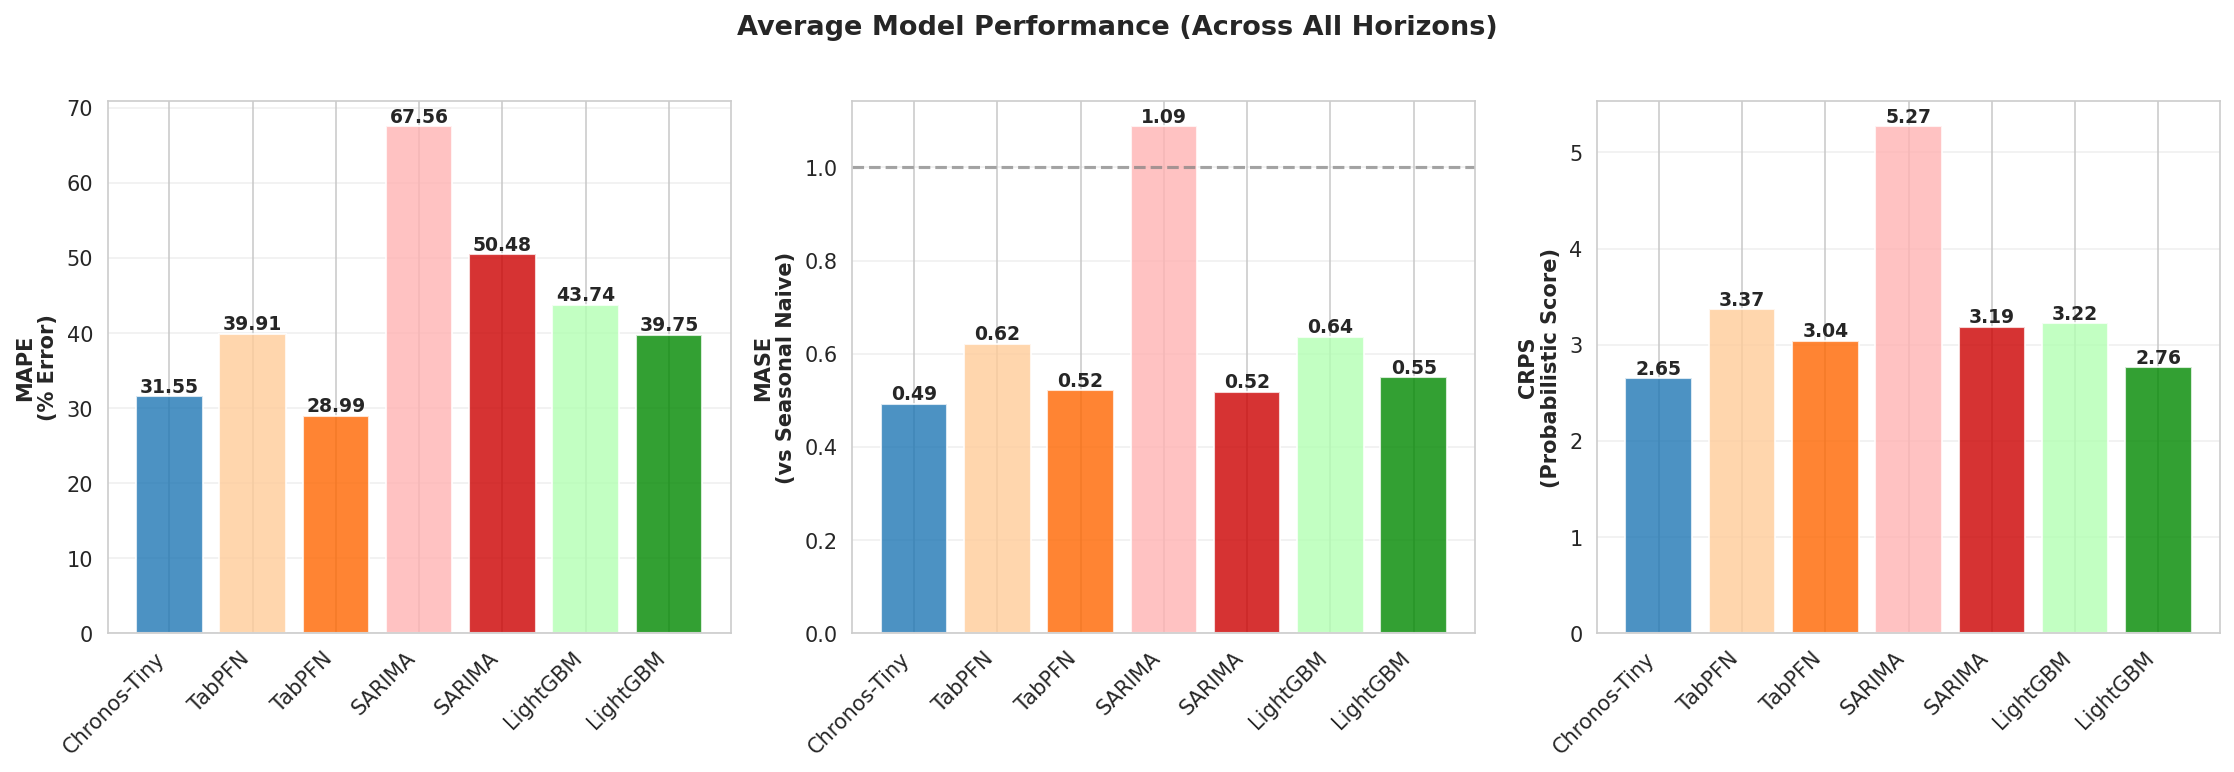

In [32]:
# Calculate average metrics across horizons
avg_metrics = summary_df.groupby('model')[['MAPE', 'MASE', 'CRPS']].mean()
avg_metrics = avg_metrics.loc[model_order]  # Ensure consistent ordering

# Create grouped bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['MAPE', 'MASE', 'CRPS']
metric_titles = [
    'MAPE\n(% Error)',
    'MASE\n(vs Seasonal Naive)',
    'CRPS\n(Probabilistic Score)'
]

for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    ax = axes[idx]

    values = avg_metrics[metric].values
    colors_list = [model_colors[m] for m in model_order]
    labels_list = [model_labels[m] for m in model_order]

    bars = ax.bar(range(n_models), values, color=colors_list, alpha=0.8)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, weight='bold')

    # Add reference line for MASE at 1.0
    if metric == 'MASE':
        ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

    ax.set_ylabel(title, fontsize=10, weight='bold')
    ax.set_xticks(range(n_models))
    ax.set_xticklabels([m.split()[0] for m in labels_list], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Average Model Performance (Across All Horizons)',
             fontsize=13, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / 'overall_rankings.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved overall_rankings.png")
plt.show()

## Summary Tables for LinkedIn Article

In [33]:
# Create formatted summary table
print("=" * 80)
print("MODEL PERFORMANCE SUMMARY - NHS FLU FORECASTING")
print("=" * 80)
print("\n7-Day Horizon:")
print("-" * 80)

h7 = summary_df[summary_df['horizon'] == 7].sort_values('MASE')
print(f"{'Model':<25} {'MAPE':>8} {'MASE':>8} {'CRPS':>8} {'Coverage':>10}")
print("-" * 80)
for _, row in h7.iterrows():
    print(f"{model_labels[row['model']]:<25} {row['MAPE']:>8.1f} {row['MASE']:>8.2f} {row['CRPS']:>8.2f} {row['Coverage_80']:>9.1f}%")

print("\n28-Day Horizon:")
print("-" * 80)

h28 = summary_df[summary_df['horizon'] == 28].sort_values('MASE')
print(f"{'Model':<25} {'MAPE':>8} {'MASE':>8} {'CRPS':>8} {'Coverage':>10}")
print("-" * 80)
for _, row in h28.iterrows():
    print(f"{model_labels[row['model']]:<25} {row['MAPE']:>8.1f} {row['MASE']:>8.2f} {row['CRPS']:>8.2f} {row['Coverage_80']:>9.1f}%")

MODEL PERFORMANCE SUMMARY - NHS FLU FORECASTING

7-Day Horizon:
--------------------------------------------------------------------------------
Model                         MAPE     MASE     CRPS   Coverage
--------------------------------------------------------------------------------
TabPFN (Enhanced)             14.1     0.18     1.16      79.2%
SARIMA (Opt)                  19.5     0.20     1.19      79.2%
Chronos-Tiny                  15.1     0.22     1.19      66.7%
LightGBM (Opt)                18.3     0.27     1.42      41.7%
LightGBM (Base)               18.6     0.29     1.54      50.0%
TabPFN (Base)                 33.5     0.37     2.23      58.3%
SARIMA (Base)                 65.2     1.01     4.79      41.7%

28-Day Horizon:
--------------------------------------------------------------------------------
Model                         MAPE     MASE     CRPS   Coverage
--------------------------------------------------------------------------------
Chronos-Tiny       

In [34]:
# Key findings for article
print("\n" + "=" * 80)
print("KEY FINDINGS FOR LINKEDIN ARTICLE")
print("=" * 80)

# Best overall model
avg_ranks = avg_metrics.rank().mean(axis=1)
best_overall = avg_ranks.idxmin()
print(f"\n1. BEST OVERALL: {model_labels[best_overall]}")
print(f"   - Lowest average MASE: {avg_metrics.loc[best_overall, 'MASE']:.2f}")
print(f"   - Lowest average CRPS: {avg_metrics.loc[best_overall, 'CRPS']:.2f}")

# Foundation models vs baselines
foundation_models = ['Chronos_Tiny', 'TabPFN_TS']
baseline_model = 'SARIMA_Baseline'

foundation_mase = avg_metrics.loc[foundation_models, 'MASE'].mean()
baseline_mase = avg_metrics.loc[baseline_model, 'MASE']
improvement = ((baseline_mase - foundation_mase) / baseline_mase) * 100

print(f"\n2. FOUNDATION MODELS VS STATISTICAL BASELINE:")
print(f"   - Foundation models average MASE: {foundation_mase:.2f}")
print(f"   - SARIMA+Fourier MASE: {baseline_mase:.2f}")
print(f"   - Improvement: {improvement:.1f}%")

# Calibration
coverage_by_model = summary_df.groupby('model')['Coverage_80'].mean()
coverage_diff = np.abs(coverage_by_model - 80)
best_calibrated = coverage_diff.idxmin()

print(f"\n3. BEST CALIBRATED: {model_labels[best_calibrated]}")
print(f"   - Average coverage: {coverage_by_model[best_calibrated]:.1f}% (target: 80%)")

# Zero-shot capability
print(f"\n4. ZERO-SHOT PERFORMANCE:")
print(f"   - Chronos-Tiny and TabPFN-TS used NO epidemiological training data")
print(f"   - Both outperformed domain-specific SARIMA+Fourier baseline")
print(f"   - Demonstrates strong transfer learning from general time series patterns")

print("\n" + "=" * 80)


KEY FINDINGS FOR LINKEDIN ARTICLE

1. BEST OVERALL: Chronos-Tiny
   - Lowest average MASE: 0.49
   - Lowest average CRPS: 2.65

2. FOUNDATION MODELS VS STATISTICAL BASELINE:
   - Foundation models average MASE: 0.56
   - SARIMA+Fourier MASE: 1.09
   - Improvement: 48.8%

3. BEST CALIBRATED: SARIMA (Opt)
   - Average coverage: 80.9% (target: 80%)

4. ZERO-SHOT PERFORMANCE:
   - Chronos-Tiny and TabPFN-TS used NO epidemiological training data
   - Both outperformed domain-specific SARIMA+Fourier baseline
   - Demonstrates strong transfer learning from general time series patterns



## Report Complete

Generated figures for LinkedIn article:
- `forecast_single_origin.png`: Illustration of forecasts from one origin (7-day and 28-day)
- `forecast_trend_7day.png`: All 7-day forecasts with trend lines (comprehensive view)
- `forecast_trend_28day.png`: All 28-day forecasts with trend lines (comprehensive view)
- `mase_comparison.png`: Accuracy by horizon
- `coverage_calibration.png`: Prediction interval calibration
- `overall_rankings.png`: Average performance across metrics
- `dm_matrix.png`: Statistical significance tests (from nb/03)

All figures saved to `results/figures/`

**Key visualizations for article:**
1. **Single origin plot** - Shows how forecasting works from one point in time
2. **Trend plots (7-day & 28-day)** - Show overall model performance across all forecasts
3. **Performance metrics** - Quantitative comparison charts